In [242]:
import pandas as pd    # Read the dataset into a dataframe and general adjustments to data points
import numpy as np    

## Ploting Libraries ##
import matplotlib.pyplot as plt 
from sklearn import tree

## Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score    # Split dataset to training sets, Perform multiple iteractions and perform cross value scores
from sklearn.preprocessing import MinMaxScaler     # Scalers to scale the dataset 
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

## Classifiers ##
from sklearn.tree import DecisionTreeClassifier    # The basic regression model using Decision tree
from sklearn.ensemble import RandomForestClassifier    # A more complex model with Random Forests
from xgboost import XGBClassifier

In [2]:
features = pd.read_csv('Data/training_set_features.csv')    # Original Dataset
labels = pd.read_csv('Data/training_set_labels.csv')    # Original Dataset
target = labels['seasonal_vaccine'].copy()    # Only the seasonal vaccine column

In [3]:
## 1. 26,707 observations
print(f'There are {len(features)} in the dataset')

## 2. Check for duplicates
df_list = [features, labels]
if sum([dataframe.duplicated().sum() for dataframe in df_list]) > 0:
    print('Dataframes have duplicates')
else:
    print('No duplicates found')

## Check for NaN / Missing Values
if sum([dataframe.isna().sum().values.sum() for dataframe in df_list]) > 0:
    print('Dataframes have missing values')
else:
    print('Dataframes have no missing values')

## 3. Check columns data types
for dtype in [object, 'number']:
    print('There are {} columns with the data type, {} data types that need to be converted. '.format(sum([len(features.select_dtypes(dtype).columns)]), dtype))

There are 26707 in the dataset
No duplicates found
Dataframes have missing values
There are 12 columns with the data type, <class 'object'> data types that need to be converted. 
There are 24 columns with the data type, number data types that need to be converted. 


In [4]:
## 1. Split the dataframe 
X_train, X_test, y_train, y_test = train_test_split(features.drop('respondent_id', axis = 1), target, test_size= .20, random_state= 420)

In [5]:
## 2. Calulate the weight of the values
# For reproductivity
np.random.seed(420)  

for dataset in [X_train, X_test]:
    missing_labels = {}
    # Determing the probability of a given value in a given column
    for column in dataset.columns:
        if dataset[column].isna().sum() > 0:
            counts = dataset[column].value_counts(normalize= True)
            missing_labels[column] = [counts.keys(), counts.values]
        ## 3. Fill all the missing values
    # For each of the missing columns, give the missing value a random value
    for column in missing_labels:
        indexs = dataset[column].loc[dataset[column].isna() == True].index
        values = np.random.choice(missing_labels[column][0], p = missing_labels[column][1], size = len(indexs))
        na_map = dict(zip(indexs, values))
        dataset[column].fillna(na_map, inplace= True)

In [6]:
## 4.  Create dummy variables
X_train_scaled = pd.get_dummies(X_train, columns= X_train.select_dtypes(object).columns)
X_test_scaled = pd.get_dummies(X_test, columns= X_train.select_dtypes(object).columns)

In [7]:
## 5. Fit and transform the dataset with the dataset
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled), columns= X_train_scaled.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled), columns= X_test_scaled.columns)

In [8]:
## Decision Tree with default parameters other than the criterion ##
tree_clf = DecisionTreeClassifier(criterion= 'entropy', random_state= 420)
tree_model = tree_clf.fit(X_train_scaled,y_train)

## Add into a list for the scores found from the classifer ## 
tree_scores = []
tree_scores.append(tree_clf.score(X_train_scaled, y_train))
tree_scores.append(tree_clf.score(X_test_scaled, y_test))
tree_scores.append(cross_val_score(tree_clf, X_test_scaled, y_test, scoring= 'accuracy').mean())

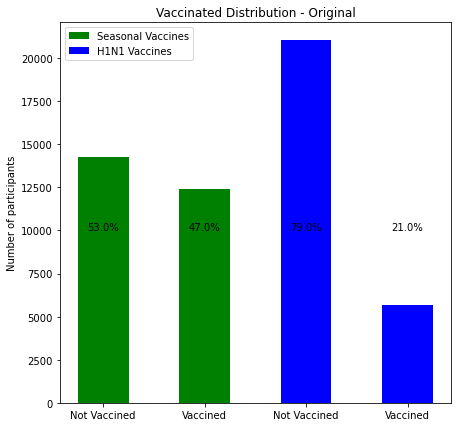

In [239]:
def add_labels(x, y):
    for index in x:
        plt.text(index, 10000, y[index], ha = 'center')
        
values = list(labels['seasonal_vaccine'].value_counts().values) + list(labels['h1n1_vaccine'].value_counts().values)
fig, ax = plt.subplots(figsize= (7, 7))
plt.xticks(np.arange(4), ['Not Vaccined', 'Vaccined', 'Not Vaccined', 'Vaccined'])
plt.bar([0,1], height= list(labels['seasonal_vaccine'].value_counts().values) , width= .5, color = 'green', label = 'Seasonal Vaccines');
plt.bar([2,3], height= list(labels['h1n1_vaccine'].value_counts().values) , width= .5, color = 'blue', label = 'H1N1 Vaccines');
ax.set_title('Vaccinated Distribution - Original');
ax.set_ylabel('Number of participants')
ax.legend();
value_list = ['{}%'.format(round(item, 2)*100) for item in (list(labels['seasonal_vaccine'].value_counts(normalize= True).values) + list(labels['h1n1_vaccine'].value_counts(normalize= True).values))]

add_labels(np.arange(4), value_list)


In [ ]:
forest_clf_v2 = RandomForestClassifier(criterion= 'entropy', max_depth= 15, max_features= 15,
                                         min_samples_leaf= 1, min_samples_split= 1, n_estimators= 300, 
                                         random_state= 420)
forest_clf_v2.fit(X_train_scaled, y_train)

y_pred = forest_clf_v2.predict(X_test_scaled)
matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot();

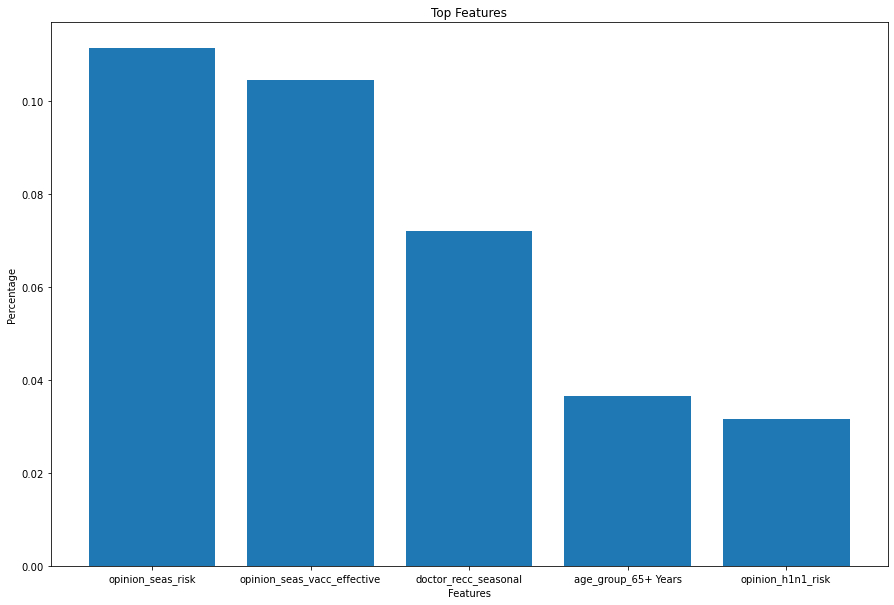

In [289]:
y = forest_clf_v2.feature_importances_
x = forest_clf_v2.feature_names_in_
paired_importance = sorted(zip(x,y), key= lambda x: x[1], reverse= True)

most_important = [name[0] for name in paired_importance[:5]]
important_values = [value[1] for value in paired_importance[:5]]

plt.figure(figsize= (15,10))
plt.title('Top Features')
plt.xlabel('Features')
plt.ylabel('Percentage')
plt.bar(most_important, important_values);